# SPAM detection with NLP processing

The project is to build a model able to dectect wether an SMS is an spam or not. To do so we will first treat the SMS with **NLP mehtod**. 

Then we will try to apply an **classification model** on the treated SMS



### package import

In [87]:
import pandas as pd
import spacy
import re
from unidecode import unidecode
import string
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords

#change the working directory if necessary
df_eng=pd.read_csv(r'C:\Users\UTILISATEUR\Desktop\Spam\Spam_dataset.csv',sep=';')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UTILISATEUR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **EDA** (Exploratory Data Analysis)

In [88]:
df_eng['Nature'].value_counts()

ham     4825
spam     747
Name: Nature, dtype: int64

Ham is over represented we risk that the model will overfit on the ham. We will ve carefull before trying to build a predictive model

### Cleaning the sms

In [89]:
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [90]:
#Remove upper case
df_eng.SMS=df_eng.SMS.str.lower()

#remove accent
df_eng.SMS=df_eng.SMS.apply(lambda text: unidecode(text))

#replace numbers
df_eng.SMS=df_eng.SMS.apply(lambda x: re.sub(r'\d{10,15}','phonenumber',x))
df_eng.SMS=df_eng.SMS.apply(lambda x: re.sub(r'\d+','number',x))

#retirer la ponctuation
df_eng.SMS=df_eng.SMS.apply(lambda text: text.translate(str.maketrans(string.punctuation ,' '*len(string.punctuation ))
                                                             ).replace(' '*4,' ').replace(' '*3,' ').replace(' '*2,' ').strip())

### Lemmatize the sms

In [91]:
#Function to lemmatize the text and take out some ponctuation and the names of peoples
def lemmatize(text):
    lemmatized_array=[]
    doc=nlp(u'{}'.format(text))
    for token in doc:
        if token.lemma_ not in ("'",",","[","]") and (not token.ent_type_ == "PER"):
            lemmatized_array.append(token.lemma_)
    return lemmatized_array

In [92]:
df_nlp_eng=df_eng.copy()

In [93]:
df_nlp_eng.SMS=df_nlp_eng.SMS.apply(lambda x: lemmatize(x))

### Stopwords treatment

In [94]:
stopWords = set(stopwords.words('english'))
stopWords.update(('nt','pl','c'))
def remove_sw(text):
    return[w for w in text if w not in stopWords]

In [95]:
df_nlp_eng.SMS=df_nlp_eng.SMS.apply(lambda text: remove_sw(text))

### Word cloud

In [96]:
df_cloud=df_nlp_eng.copy()

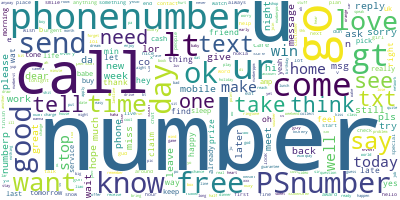

In [97]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
df_cloud.SMS=df_cloud.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

##### Word cloud of spams and non spam

In [98]:
df_cloud_ham=df_nlp_eng[df_nlp_eng['Nature']=='ham']
df_cloud_spam=df_nlp_eng[df_nlp_eng['Nature']=='spam']

c:\Users\UTILISATEUR\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


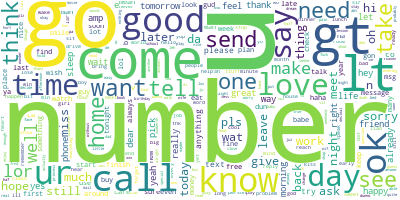

In [99]:
df_cloud_ham.SMS=df_cloud_ham.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud_ham.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

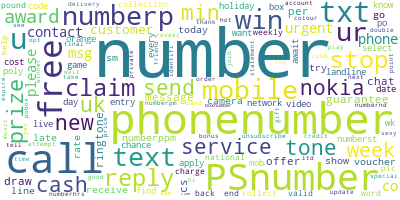

In [100]:
df_cloud_spam.SMS=df_cloud_spam.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud_spam.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Predictive model

#### Downsampling the data

In [101]:
# check percentage of data - states how much data needs to be balanced
print(str(round(747/4825,2))+'%')

0.15%


In [102]:
#clear empty fields
df_nlp_eng=df_nlp_eng[df_nlp_eng['SMS'].map(len)>0]

#we separe the two type of data
df_ham=df_nlp_eng[df_nlp_eng['Nature']=='ham']
df_spam=df_nlp_eng[df_nlp_eng['Nature']=='spam']

In [103]:
df_ham

,Nature,SMS
0,ham,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,"[ok, lar, joke, wif, u, oni]"
3,ham,"[u, dun, say, early, hor, u, already, say]"
4,ham,"[nah, I, think, go, usf, live, around, though]"
6,ham,"[even, brother, like, speak, I, treat, I, like..."
...,...,...
5565,ham,"[huh, lei]"
5568,ham,"[u, b, go, esplanade, fr, home]"
5569,ham,"[pity, mood, suggestion]"
5570,ham,"[guy, bitching, I, act, like, interested, buy,..."


In [104]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [105]:
# get the balanced dataset
df_model= pd.concat([df_spam , df_ham_downsampled])

In [106]:
#Change the categorical variable to numerical one
df_model['is_spam']=df_model['Nature'].apply(lambda x: 1 if x=='spam'else 0)

In [107]:
df_model

,Nature,SMS,is_spam
2,spam,"[free, entry, number, wkly, comp, win, fa, cup...",1
5,spam,"[freemsg, hey, darle, number, week, word, back...",1
8,spam,"[winner, value, network, customer, select, rec...",1
9,spam,"[mobile, number, month, u, r, entitled, update...",1
11,spam,"[six, chance, win, cash, number, number, numbe...",1
...,...,...,...
1046,ham,"[come, round]",0
963,ham,"[watch, cartoon, listening, music, amp, eve, g...",0
2203,ham,"[man, carlos, definitely, come, mu, tonight, e...",0
5029,ham,"[go, chase, run, cross, street]",0


#### Compute the TF-IDF score

In [108]:
#Join the list of word to apply the tf_idf
df_model.SMS=df_model.SMS.apply(lambda x: ' '.join(x))
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_model.SMS)

In [109]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_model.index,inplace=True)

In [110]:
#Visualisation of the most frequent words
pd.DataFrame(tfidf_df.astype(bool).sum(axis=0),columns=['Tf-idf']).sort_values(by=['Tf-idf'],ascending=False).head(50)

,Tf-idf
number,686
phonenumber,377
call,360
psnumber,234
free,181
get,170
txt,152
ur,144
numberp,136
win,133


In [111]:
#Concatenate the score of tf-idf and the initial dataframe
df_model=pd.concat([df_model , tfidf_df],axis=1)

In [112]:
df_model

,Nature,SMS,is_spam,aah,ab,aberdeen,abiola,able,abroad,abt,...,yrs,ystrday,ythe,yup,zac,ze,zealand,zebra,zoe,zouk
2,spam,free entry number wkly comp win fa cup final t...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,spam,freemsg hey darle number week word back like f...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,spam,winner value network customer select receivea ...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,spam,mobile number month u r entitled update late c...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,spam,six chance win cash number number number pound...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,ham,come round,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
963,ham,watch cartoon listening music amp eve go templ...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2203,ham,man carlos definitely come mu tonight excuse,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5029,ham,go chase run cross street,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Random Forest Classifier Reg

In [113]:
X_model=df_model[df_model.columns.difference(['Nature', 'SMS','is_spam'])]
y=df_model[['is_spam']]
X_train, X_test, y_train, y_test = train_test_split( X_model, y, test_size=0.33, random_state=42)

In [114]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

<ipython-input-114-8a5c39954b34>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


#### Visualisation error

In [115]:
cm = confusion_matrix(y_test,y_pred)

Text(33.0, 0.5, 'Actual')

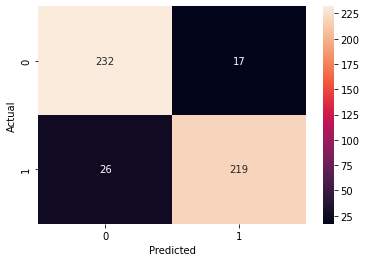

In [116]:
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#### Model on the whole dataset

In [176]:
df_test=df_nlp_eng.copy()

In [177]:
#Join the list of word to apply the tf_idf
df_test.SMS=df_test.SMS.apply(lambda x: ' '.join(x))
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_test.SMS)

In [178]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_test.index,inplace=True)

In [179]:
#Concatenate the score of tf-idf and the initial dataframe
df_test=pd.concat([df_test , tfidf_df],axis=1)

Text(33.0, 0.5, 'Actual')

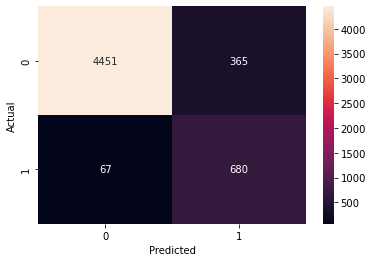

In [180]:
df_test['is_spam']=df_test['Nature'].apply(lambda x: 1 if x=='spam'else 0)


X=df_test[df_test.columns.difference(['Nature', 'SMS','is_spam'])]
X=X[X_model.columns]
y=df_test[['is_spam']]
y_pred=clf.predict(X)
cm = confusion_matrix(y,y_pred)

# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### To develop:
* n-gram
* model to use
* TF-IDF

Can help:

https://dimensionless.in/spam-detection-with-natural-language-processing-part-2/

https://www.analyticsvidhya.com/blog/2021/09/performing-email-spam-detection-using-bert-in-python/
